In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale
import statsmodels.api as sm
import scipy
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from scipy.stats import norm

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Step 1. 
Choose about 3-6 variables from your dataset (2-3 – target variables, the rest - predictors).

In [3]:
df = pd.read_csv('datasets/data_by_year.csv', index_col='year', parse_dates=['year'])

In [4]:
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
year,,,,,,,,,,,,,
1920-01-01,0.631242,0.515750,238092.997135,0.418700,0.354219,0.216049,-12.654020,0.082984,113.226900,0.498210,0.610315,2,1
1921-01-01,0.862105,0.432171,257891.762821,0.241136,0.337158,0.205219,-16.811660,0.078952,102.425397,0.378276,0.391026,2,1
1922-01-01,0.828934,0.575620,140135.140496,0.226173,0.254776,0.256662,-20.840083,0.464368,100.033149,0.571190,0.090909,5,1
1923-01-01,0.957247,0.577341,177942.362162,0.262406,0.371733,0.227462,-14.129211,0.093949,114.010730,0.625492,5.205405,0,1
1924-01-01,0.940200,0.549894,191046.707627,0.344347,0.581701,0.235219,-14.231343,0.092089,120.689572,0.663725,0.661017,10,1


In [4]:
target_cols = ['acousticness', 'danceability', 'popularity']
predictor_cols = ['instrumentalness', 'tempo']

## Step 2. 
Analyze stationarity of a process (for mathematical expectation and variance) for all chosen variables. Make them more stationary if needed.

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


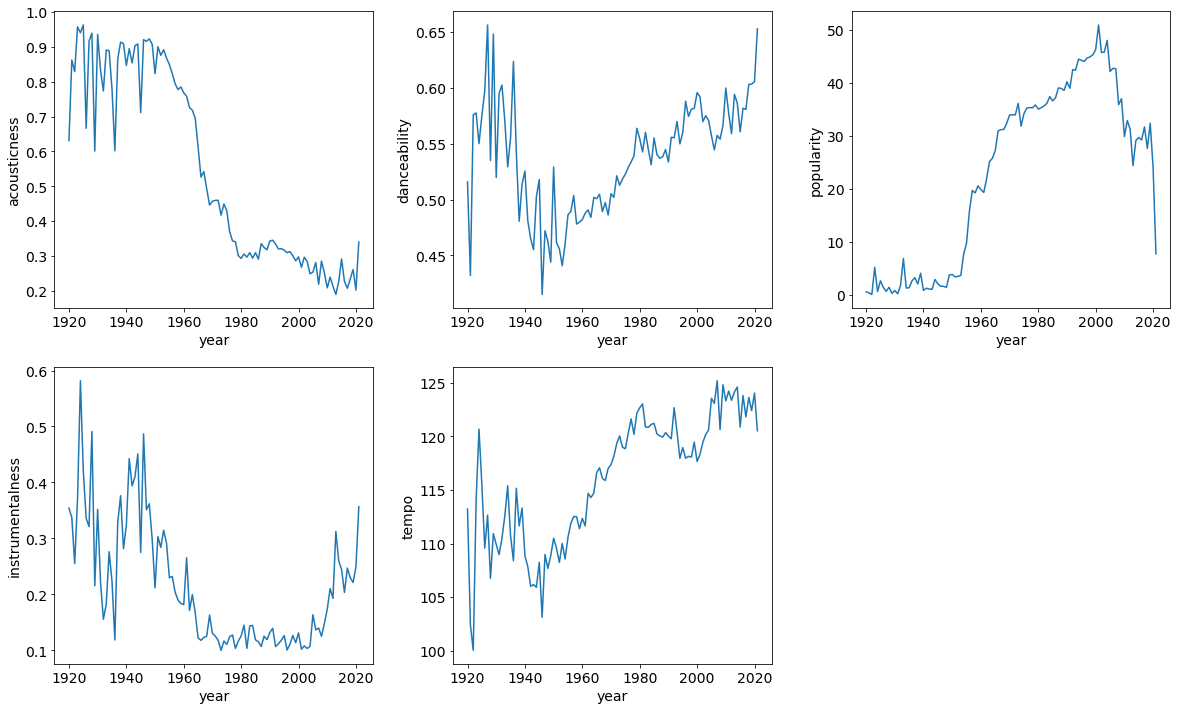

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
#fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.25)

for ax, col in zip(axes.flat, target_cols+predictor_cols):
    ax.plot(df.index, df[col])
    ax.set_ylabel(col)
    ax.set_xlabel('year')
axes[-1,-1].set_axis_off()

plt.savefig('images/2_initial_series.png', dpi=None, quality=95, transparent=False)


D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


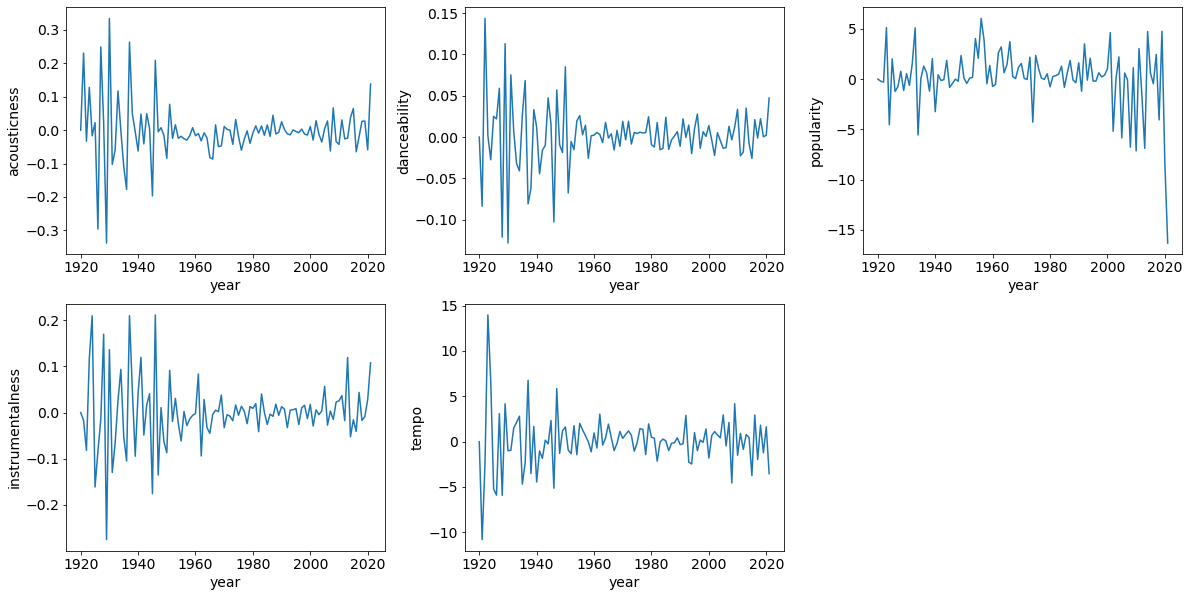

In [6]:
for col in target_cols+predictor_cols:
    df[f"{col}_diff"] = df[col] - df[col].shift(1)
    df[f"{col}_diff"][0] = 0

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.2, wspace=0.25)

for ax, col in zip(axes.flat, target_cols+predictor_cols):
    ax.plot(df.index, df[f"{col}_diff"])
    ax.set_ylabel(col)
    ax.set_xlabel('year')

axes[-1,-1].set_axis_off()

plt.savefig('images/2_differ_series.png', dpi=None, quality=95, transparent=False)


D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


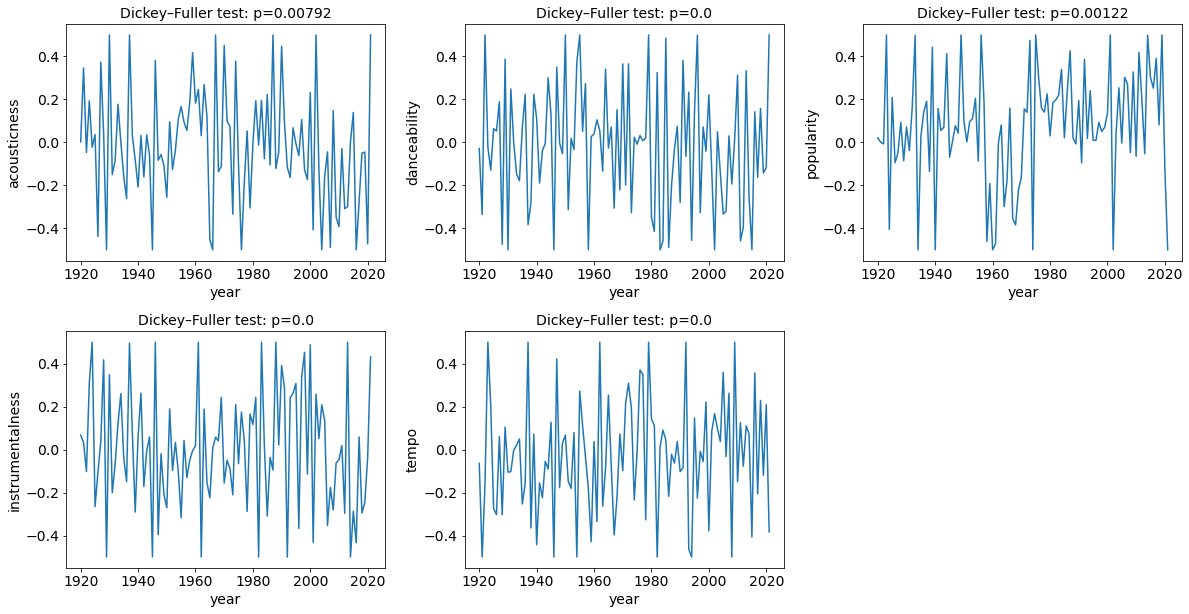

In [7]:
indexes = df.index.to_numpy()

intervals = np.array(range(len(indexes))).reshape(6, -1)

def normilize(data, indexes):
    for row in indexes:
        data[row] = minmax_scale(data[row])
    return data

for col in target_cols+predictor_cols:
    df[f"{col}_diff_norm"] = normilize(df[f"{col}_diff"].to_numpy(), intervals)-0.5


fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

for ax, col in zip(axes.flat, target_cols+predictor_cols):
    ax.plot(df.index, df[f"{col}_diff_norm"])
    ax.set_ylabel(col)
    ax.set_xlabel('year')
    ax.set_title(f"Dickey–Fuller test: p={np.round(sm.tsa.stattools.adfuller(df[f'{col}_diff_norm'])[1], 5)}")
axes[-1,-1].set_axis_off()

plt.savefig('images/2_normalized_series.png', dpi=None, quality=95, transparent=False)



## Step 3. 
Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets.

In [8]:
transf_target_cols = ['acousticness_diff_norm', 'danceability_diff_norm', 'popularity_diff_norm']
transf_pred_cols = ['instrumentalness_diff_norm', 'tempo_diff_norm']

### Autocorreleation

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  if sys.path[0] == '':


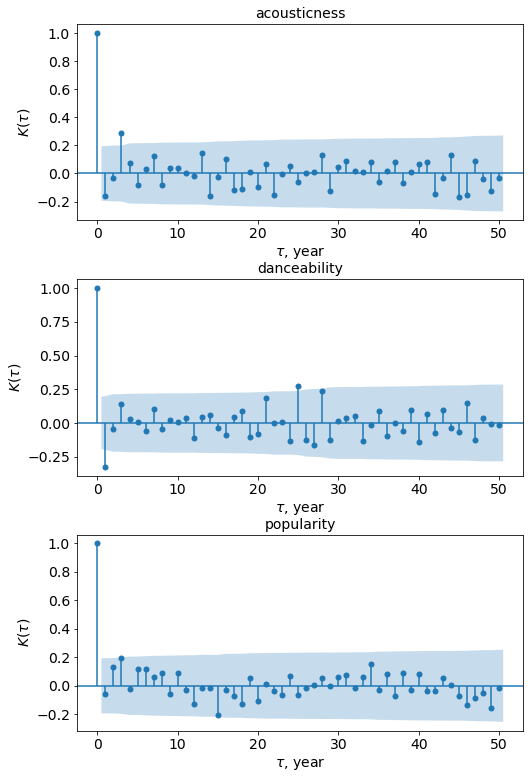

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(8, 13))
plt.subplots_adjust(hspace=0.3)

for ax, col, col_name in zip(axes, transf_target_cols, target_cols):
    #pd.plotting.autocorrelation_plot(df[col][1:], ax=ax)
    sm.graphics.tsa.plot_acf(df[col], lags=50, ax=ax)
    ax.set_ylabel(r"$K(\tau)$")
    ax.set_xlabel(r'$\tau$, year')

    ax.set_title(col_name)
    
plt.savefig('images/3_auto_corr.png', dpi=None, quality=95, transparent=False)


### Mutual (cross) correlation

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


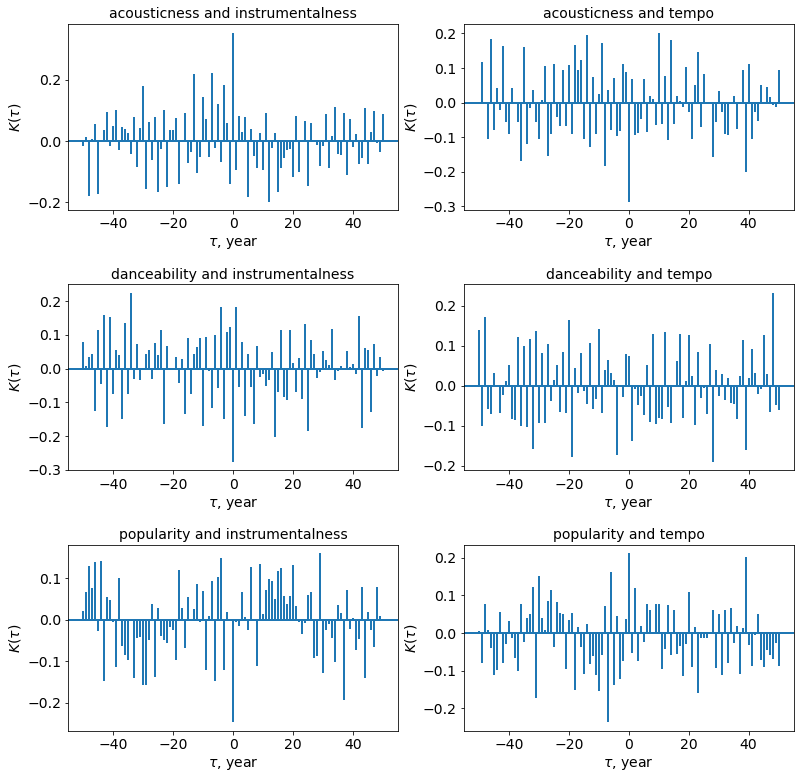

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(13, 13))
plt.subplots_adjust(hspace=0.4)

for i in range(3):
    for j in range(2):  
        axes[i, j].xcorr(df[transf_target_cols[i]], df[transf_pred_cols[j]], usevlines=True, maxlags=50, normed=True, lw=2)
        axes[i, j].set_title(f"{target_cols[i]} and {predictor_cols[j]}")
        axes[i, j].set_ylabel(r"$K(\tau)$")
        axes[i, j].set_xlabel(r'$\tau$, year')
        
plt.savefig('images/3_cross_corr.png', dpi=None, quality=95, transparent=False)


## Step 4. 
Filter high frequencies (noise) with chosen 2 filters for target variables.

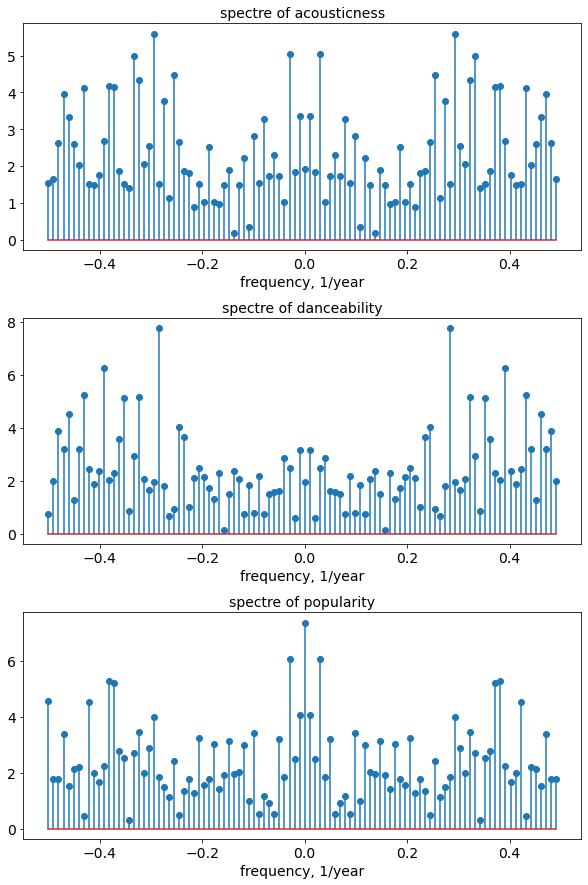

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plt.subplots_adjust(hspace=0.3)

for ax, col, col_name in zip(axes, transf_target_cols, target_cols):
    spectre=np.abs(np.fft.fft(df[col]))
    freqs = np.fft.fftfreq(len(spectre), d=1)
    ax.stem(freqs, spectre)
    ax.set_title(f"spectre of {col_name}")
    ax.set_xlabel('frequency, 1/year')


In [12]:
def high_freq_filter_1(signal, part=0.25):
    spectre = np.fft.fftshift(np.fft.fft(signal))
    n = int(len(signal)/2*part)
    spectre[:n] = complex(0, 0)
    spectre[-n:] = complex(0, 0)
    filtered_signal = np.fft.ifft(np.fft.ifftshift(spectre)).real
    
    return filtered_signal

In [13]:
def rolling_window(data, n):
    return pd.Series(data).rolling(n).mean().to_numpy()

def high_freq_filter_2(signal, width=20):
    
    filtered_signal = rolling_window(signal, width)
    
    return filtered_signal

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


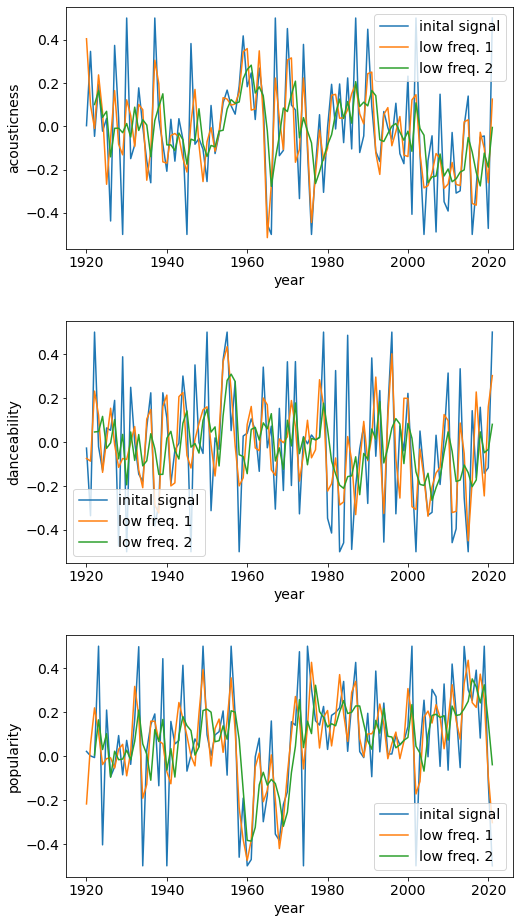

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(8, 16))
plt.subplots_adjust(hspace=0.3)

signal_list = []
low_freq_list_1 = []
low_freq_list_2 = []

for ax, col, col_name in zip(axes, transf_target_cols, target_cols):
    signal = df[col]
    low_freq_1 = high_freq_filter_1(signal, part = 0.4)
    low_freq_2 = high_freq_filter_2(signal, 3)
    signal_list.append(signal.values)
    low_freq_list_1.append(low_freq_1)
    low_freq_list_2.append(low_freq_2)
    
    x = df.index
    ax.plot(x, signal, label='inital signal')
    ax.plot(x, low_freq_1, label='low freq. 1')
    ax.plot(x, low_freq_2, label='low freq. 2')
    ax.set_ylabel(col_name)
    ax.set_xlabel('year')

    ax.legend()
    
plt.savefig('images/4_filtered_series.png', dpi=None, quality=95, transparent=False)

plt.show()

## Step 5. 
Estimate spectral density function for  with and without filtering.

In [15]:
def spectral_density(signal):
    corr_function = scipy.signal.correlate(signal, signal)
    fft = np.fft.fft(corr_function)
    return np.abs(fft)

In [16]:
for i in range(len(low_freq_list_2)):
    low_freq_list_2[i][:3] = 0

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  


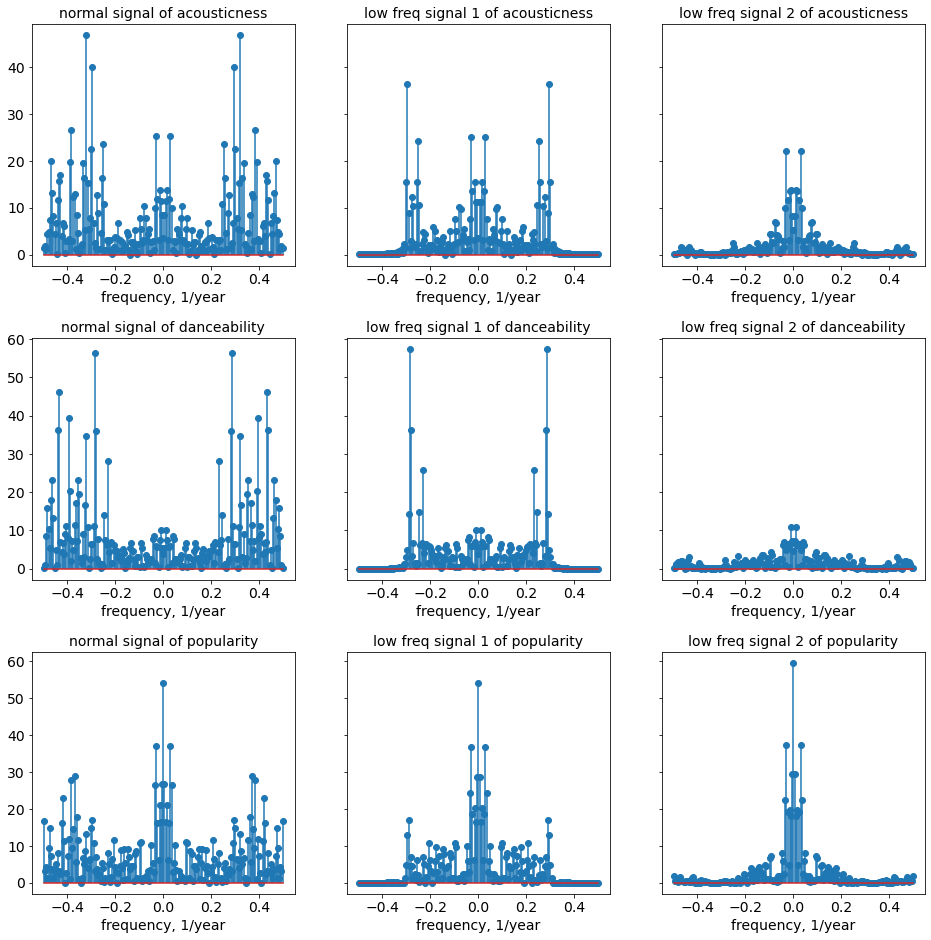

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16), sharey='row')
plt.subplots_adjust(hspace=0.3)

all_signals = [signal_list, low_freq_list_1, low_freq_list_2]
signal_names = ['normal signal', 'low freq signal 1', 'low freq signal 2']

for i in range(3):
    for j in range(3):
        freqs = np.fft.fftfreq(len(spectral_density(all_signals[j][i])), d=1)
        axes[i, j].stem(freqs, spectral_density(all_signals[j][i]))
        axes[i, j].set_title(f"{signal_names[j]} of {target_cols[i]}")
        axes[i, j].set_xlabel('frequency, 1/year')

plt.savefig('images/5_spectral_density.png', dpi=None, quality=95, transparent=False)


## Step 6. 
Built auto-regression model filtered and non-filtered data. To analyze residual error and to define appropriate order of model.

In [18]:
from statsmodels.tsa.ar_model import AutoReg

In [19]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html
res = AutoReg(all_signals[0][0], lags = 5, trend='n',old_names=False).fit()

In [20]:
def find_best_model(data, init_model, lags):
    models = []
    aics = []
    for lag in lags:
        model = init_model(data, lags = lag, old_names=False).fit()
        models.append(model)
        aics.append(model.aic)
    best_aic = min(aics)
    best_model = models[aics.index(best_aic)]
    
    return best_model, lags[aics.index(best_aic)]

In [21]:
models = np.zeros((3, 3), dtype='object')
best_lags = np.zeros((3, 3), dtype='int')

lags = list(range(1, 16))

for i in range(3):
    for j in range(3):
        signal = all_signals[j][i]
        models[i, j], best_lags[i, j] = find_best_model(signal, AutoReg, lags)

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


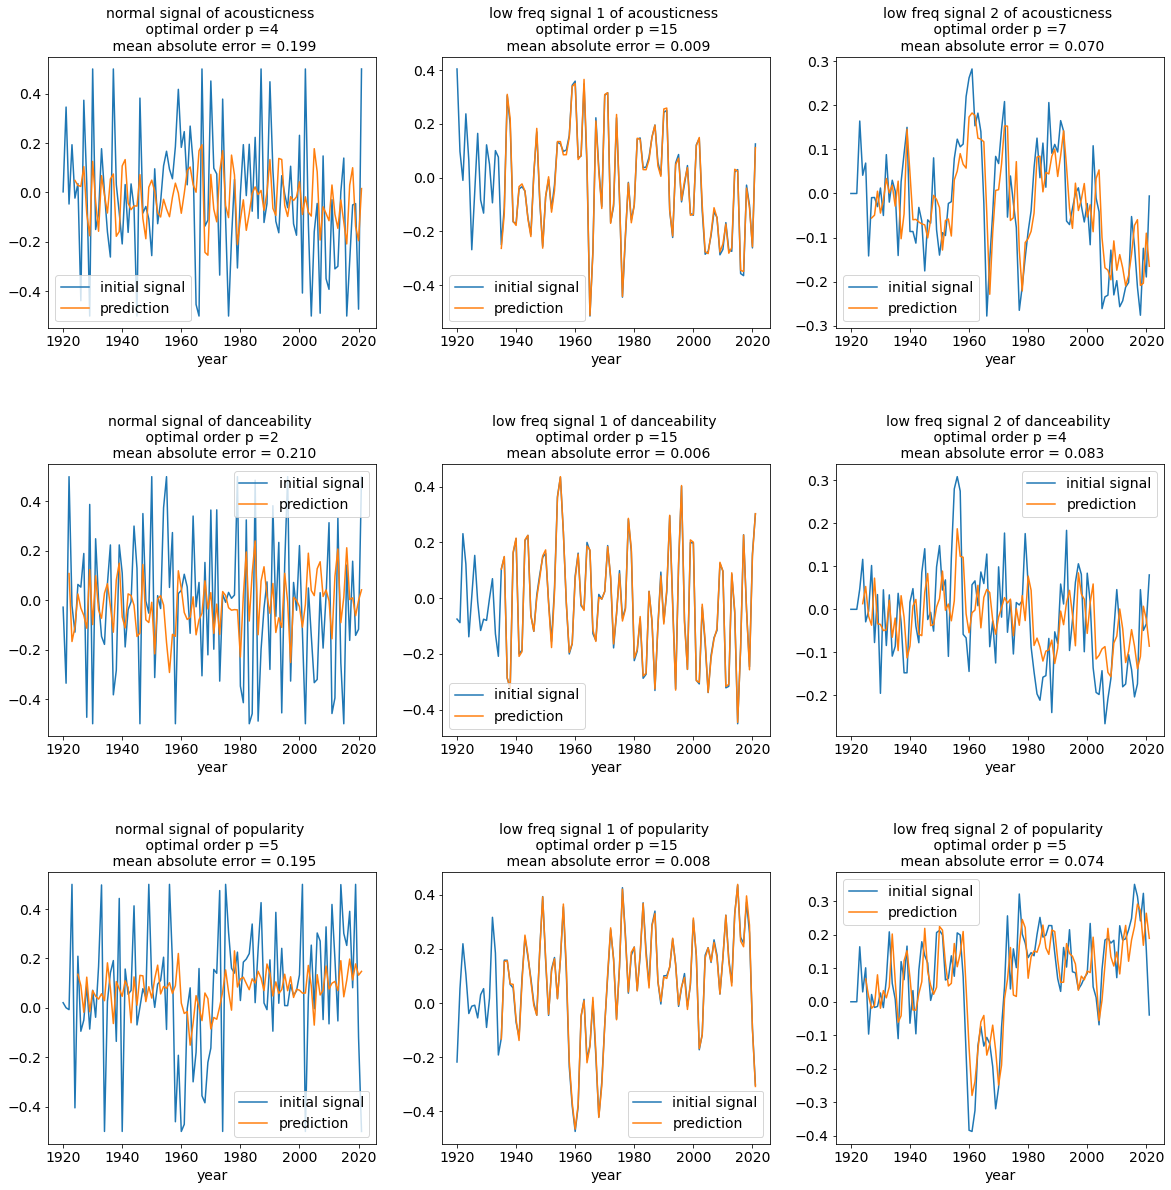

In [59]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
auto_reg_residuals = np.zeros((3, 3), dtype='object')
auto_reg_mae = np.zeros((3, 3))

x = df.index
for i in range(3):
    for j in range(3):
        signal = all_signals[j][i]
        model = models[i, j]
        lag = best_lags[i, j]
        prediction = model.fittedvalues
        mae = mean_absolute_error(signal[lag:], prediction)
        auto_reg_residuals[i, j] = prediction - signal[lag:]
        auto_reg_mae[i, j] = mae
        
        axes[i, j].plot(x, signal, label="initial signal")
        axes[i, j].plot(x[lag:], prediction, label='prediction')
        axes[i, j].set_title(f"{signal_names[j]} of {target_cols[i]} \n optimal order p ={lag} \n mean absolute error = {mae :.3f}")
        axes[i, j].set_xlabel('year')

        axes[i, j].legend()

plt.savefig('images/6_model_inference.png', dpi=300, quality=95, transparent=False)
plt.show()

    
    

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


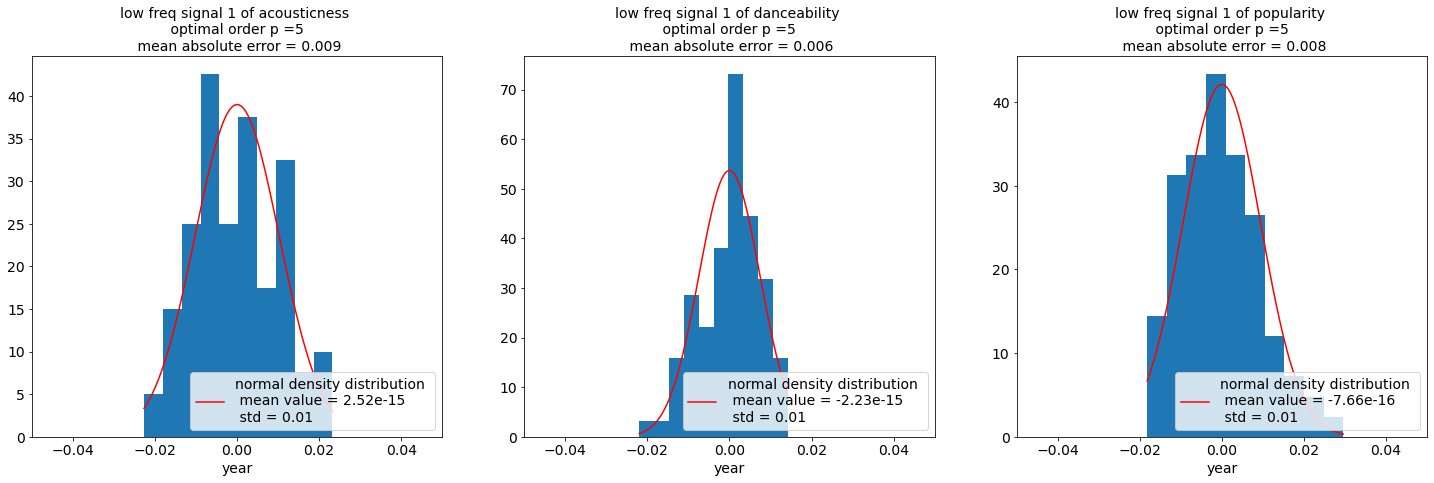

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))
plt.subplots_adjust(hspace=0.5)
j=1
for i in range(3):
    #sns.histplot(auto_reg_residuals[i, j], ax=axes[i,j])
    residuals = pd.Series(auto_reg_residuals[i, j])
    norm_params = norm.fit(residuals)
    x_r = np.linspace(min(residuals), max(residuals), 100)
    axes[i].plot(x_r, norm.pdf(x_r, *norm_params), c='r', label=f'normal density distribution \n mean value = {norm_params[0]:.3} \n std = {norm_params[1]:.2f}')

    axes[i].hist(auto_reg_residuals[i, j], density=True)
    
    axes[i].set_title(f"{signal_names[j]} of {target_cols[i]} \n optimal order p ={lag} \n mean absolute error = {auto_reg_mae[i, j] :.3f}")
    axes[i].set_xlabel('year')
    axes[i].set_xlim(-0.05, 0.05)
    axes[i].legend(loc='lower right')


plt.savefig('images/6_model_residuals.png', dpi=300, quality=95, transparent=False)
plt.show()

In [47]:
import datetime
from dateutil.relativedelta import relativedelta

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


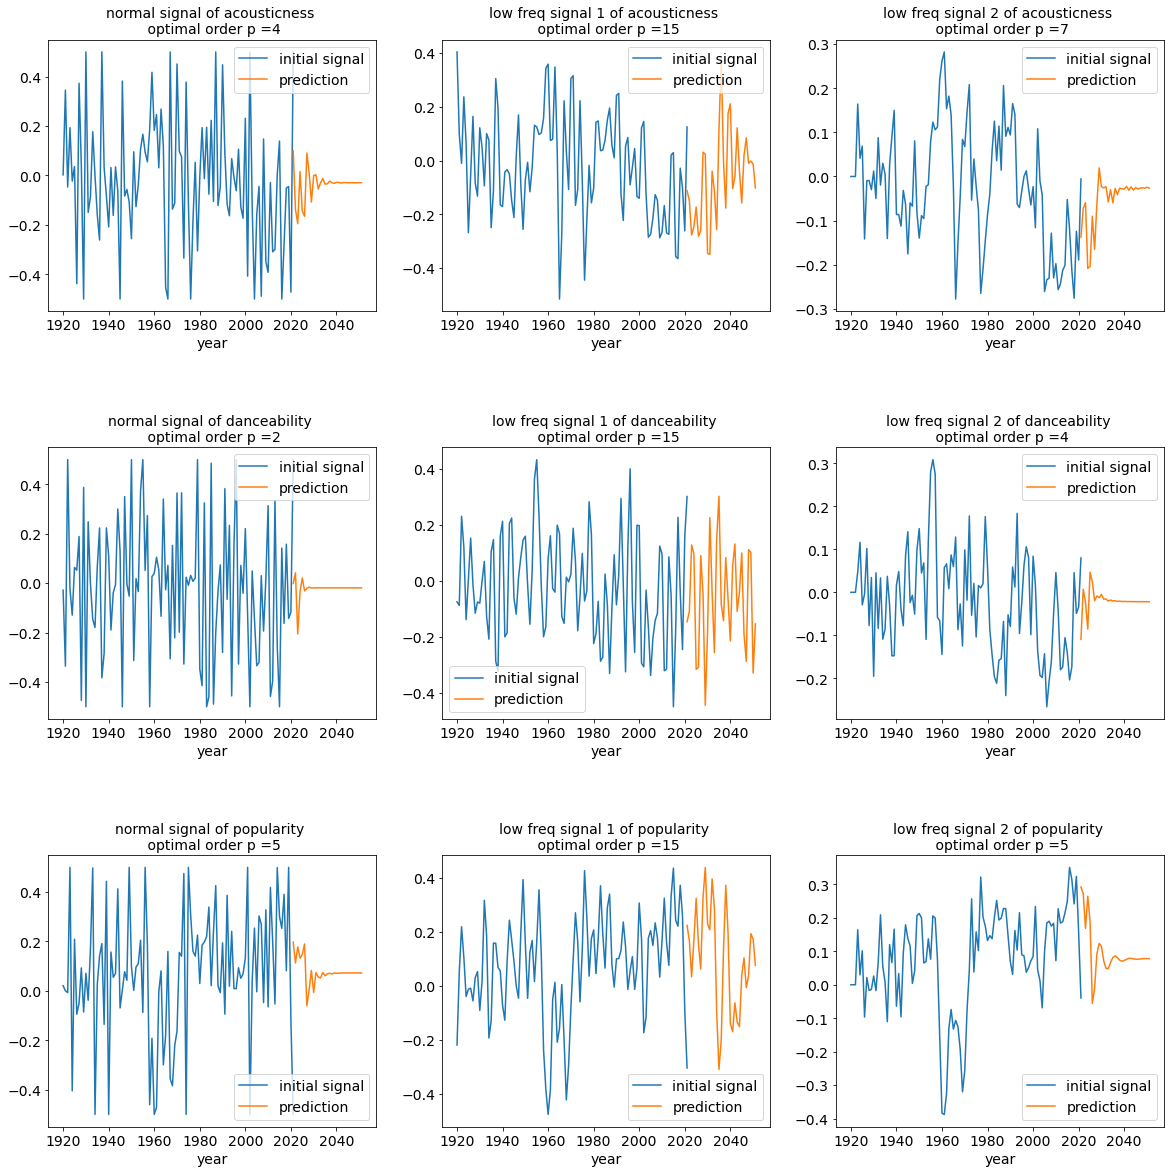

In [57]:
# Plot prediction for 30 years
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)

pred_len = 30

for i in range(3):
    for j in range(3):
        lag = best_lags[i, j]
        x = df.index
        start = len(x[lag:])
        new_x = [datetime.datetime.strptime("2021-01-01", "%Y-%m-%d") + relativedelta(years=i) for i in range(0, pred_len+1)]
        predictions = models[i, j].predict(start=start, end=start+pred_len)
        axes[i, j].plot(x, all_signals[j][i], label="initial signal")
        axes[i, j].plot(new_x, predictions, label='prediction')
        axes[i, j].set_title(f"{signal_names[j]} of {target_cols[i]} \n optimal order p ={lag}")
        axes[i, j].set_xlabel('year')

        
        axes[i, j].legend()

plt.savefig('images/6_model_predictions.png', dpi=300, quality=95, transparent=False)



## Step 7. 
Build model in a form of linear dynamical system, using chosen predictors. To analyze residual error and to define appropriate order of model.

In [49]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [50]:
var_models = np.zeros((3, 3), dtype='object')


for i in range(3):
    for j in range(3):
        signal = all_signals[j][i]
        data = np.hstack([signal.reshape(-1, 1), df[transf_pred_cols].values])
        var_models[i, j] = VAR(data).fit(maxlags=15, ic='aic')

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


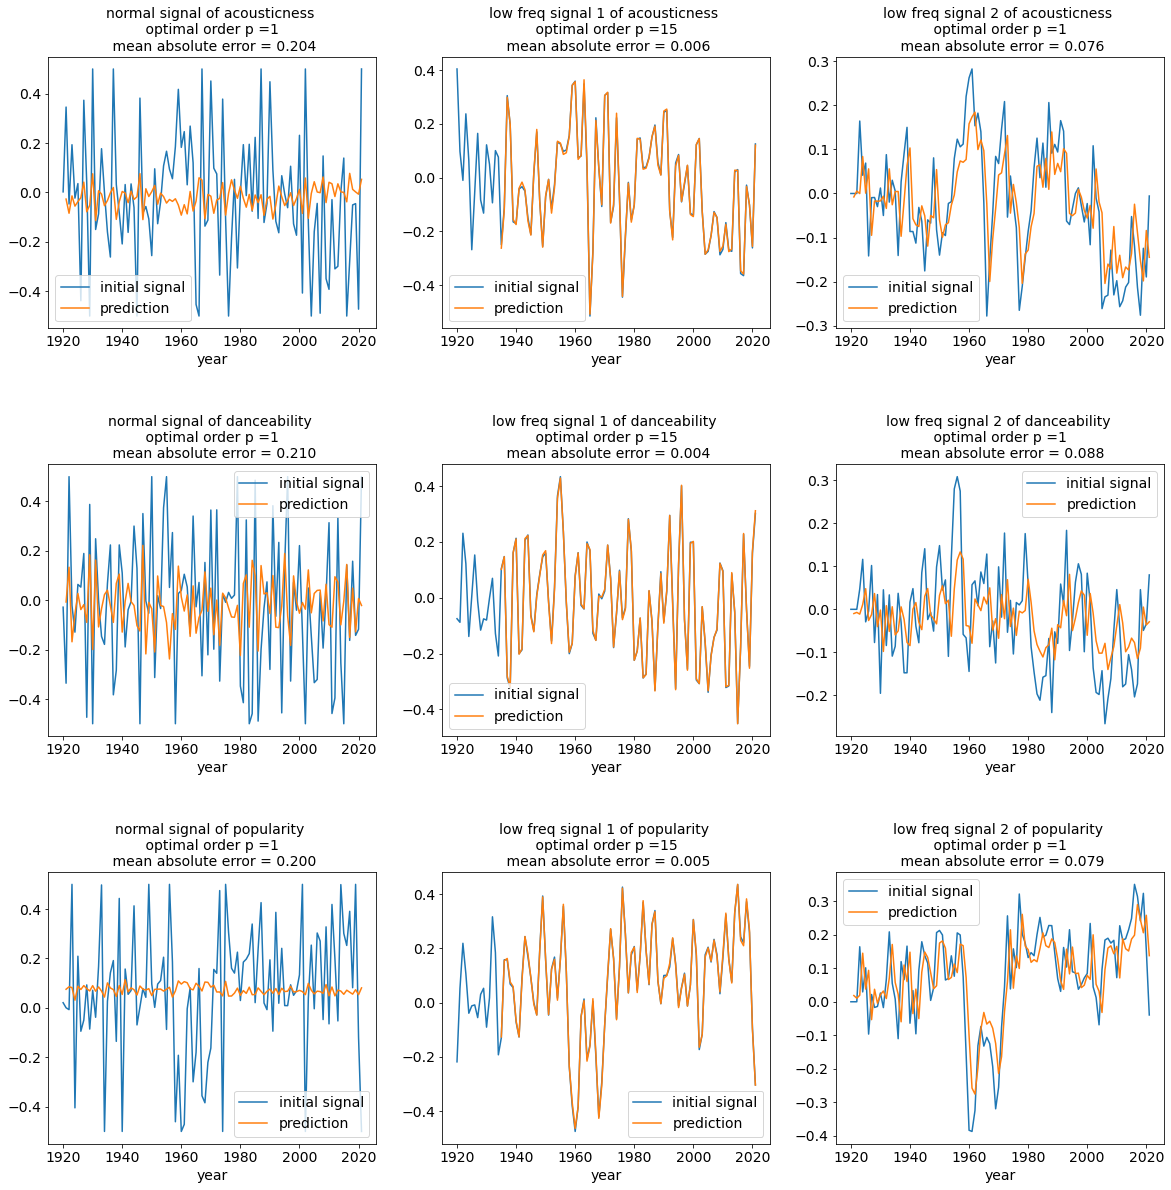

In [60]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
linear_model_residuals=np.zeros((3, 3), dtype='object')
linear_model_mae = np.zeros((3, 3))

x = df.index
for i in range(3):
    for j in range(3):
        signal = all_signals[j][i]
        model = var_models[i, j]
        lag = model.k_ar
        
        prediction = model.fittedvalues[:, 0]
        mae = mean_absolute_error(signal[lag:], prediction)
        linear_model_mae[i, j] = mae
        linear_model_residuals[i, j] = prediction - signal[lag:]

        axes[i, j].plot(x, signal, label="initial signal")
        axes[i, j].plot(x[model.k_ar:], prediction, label='prediction')
        axes[i, j].set_title(f"{signal_names[j]} of {target_cols[i]} \n optimal order p ={lag} \n mean absolute error = {mae :.3f}")
        axes[i, j].set_xlabel('year')

        axes[i, j].legend()
    
plt.savefig('images/7_dynamic_model_inf.png', dpi=300, quality=95, transparent=False)

plt.show()


D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


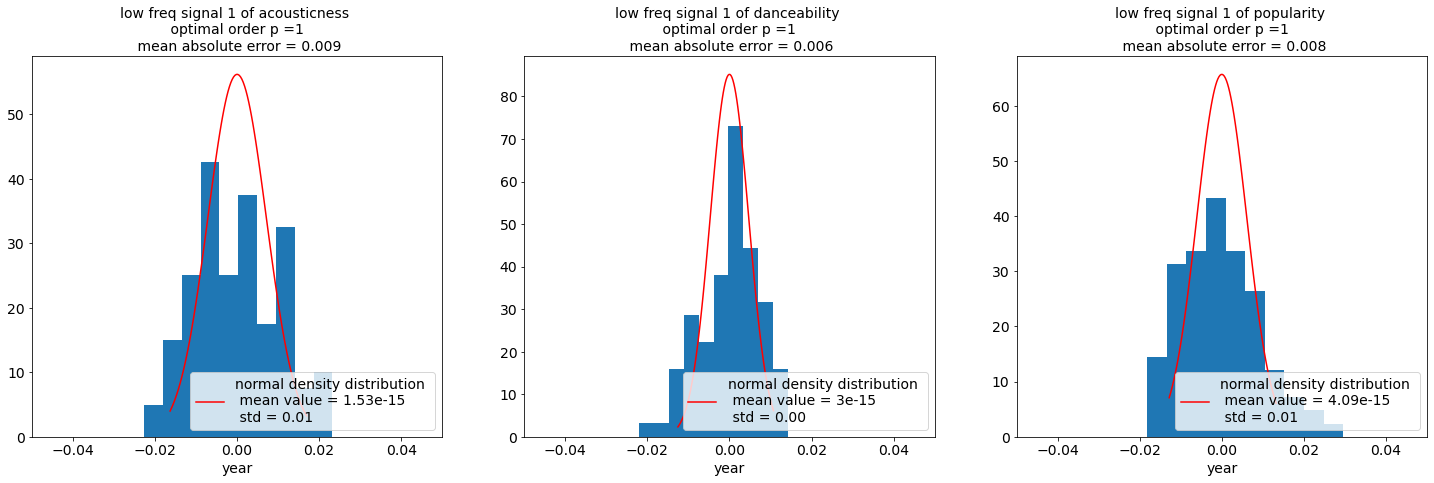

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))
plt.subplots_adjust(hspace=0.5)
j=1
for i in range(3):
    #sns.histplot(auto_reg_residuals[i, j], ax=axes[i,j])
    residuals = pd.Series(linear_model_residuals[i, j])
    norm_params = norm.fit(residuals)
    x_r = np.linspace(min(residuals), max(residuals), 100)
    axes[i].plot(x_r, norm.pdf(x_r, *norm_params), c='r', label=f'normal density distribution \n mean value = {norm_params[0]:.3} \n std = {norm_params[1]:.2f}')

    axes[i].hist(auto_reg_residuals[i, j], density=True)
    
    axes[i].set_title(f"{signal_names[j]} of {target_cols[i]} \n optimal order p ={lag} \n mean absolute error = {auto_reg_mae[i, j] :.3f}")
    axes[i].set_xlabel('year')
    axes[i].set_xlim(-0.05, 0.05)
    axes[i].legend(loc='lower right')


plt.savefig('images/7_model_residuals.png', dpi=None, quality=95, transparent=False)
plt.show()

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


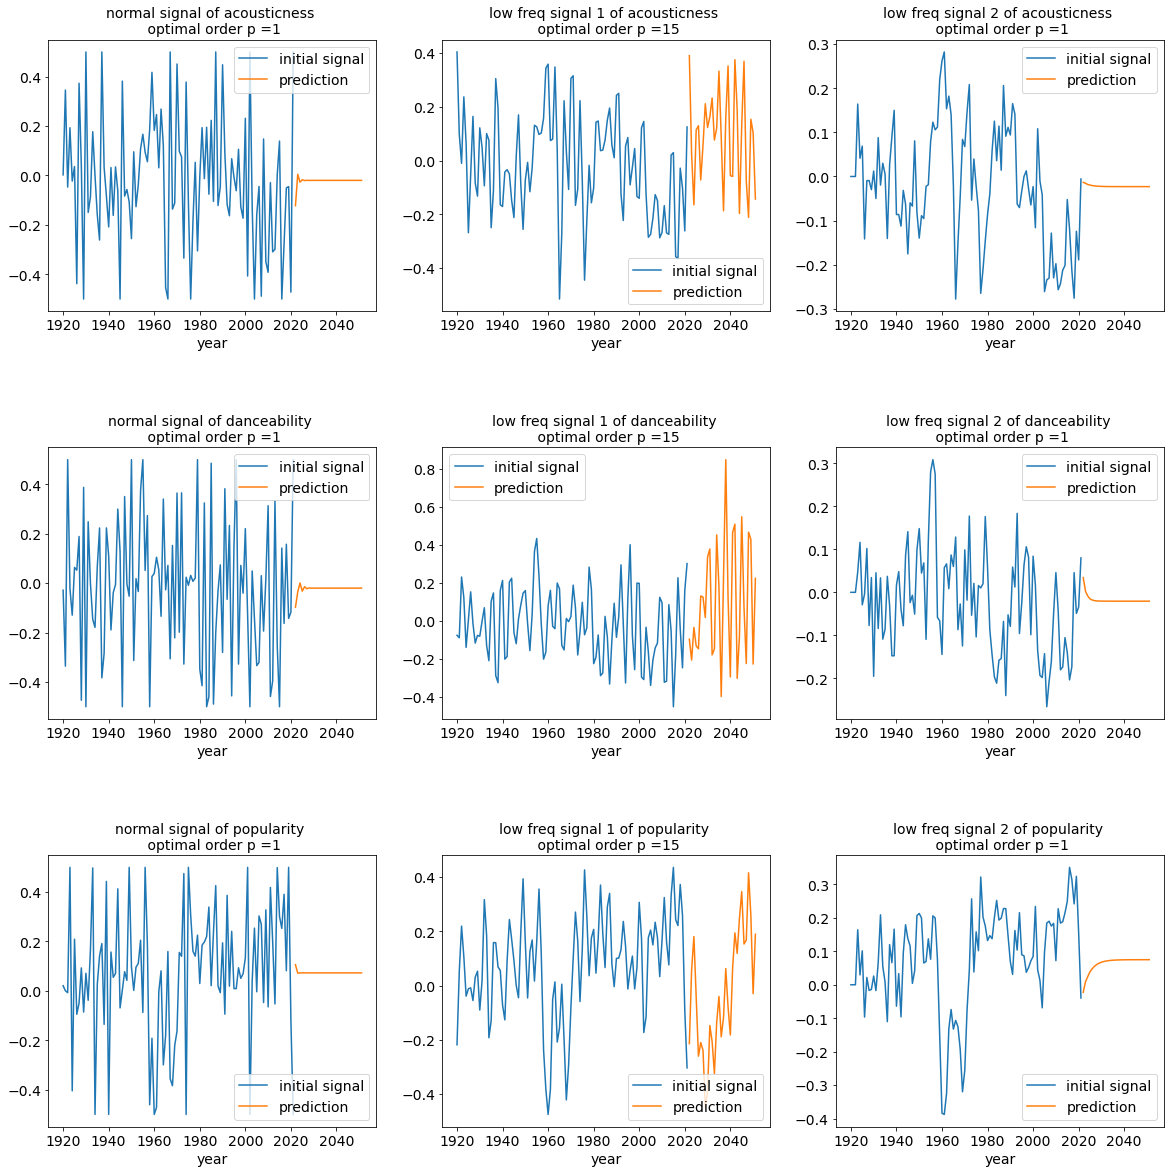

In [62]:
# Plot prediction for 30 years
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)

pred_len = 30

for i in range(3):
    for j in range(3):
        signal = all_signals[j][i]
        x = df.index
        start = len(x[model.k_ar:])
        new_x = [datetime.datetime.strptime("2021-01-01", "%Y-%m-%d") + relativedelta(years=i) for i in range(0, pred_len+1)]
        model = var_models[i, j]
        lag_order = model.k_ar
        data = np.hstack([signal.reshape(-1, 1), df[transf_pred_cols].values])

        predictions = model.forecast(data[-lag_order:], 30)[:, 0]
        axes[i, j].plot(x, all_signals[j][i], label="initial signal")
        axes[i, j].plot(new_x[1:], predictions, label='prediction')
        axes[i, j].set_title(f"{signal_names[j]} of {target_cols[i]} \n optimal order p ={lag_order}")
        axes[i, j].set_xlabel('year')

        axes[i, j].legend()
        
plt.savefig('images/7_dynamical_model_predictions.png', dpi=300, quality=95, transparent=False)
       